In [1]:
library(tidyverse)
library(tidymodels)
install.packages("kknn")
library(RColorBrewer)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

In [2]:
heart_data <- read_csv("https://raw.githubusercontent.com/Mr-Slope/DSCI-100_Group_Project/main/processed.cleveland.data",
                       col_names=c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", 
                                   "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"))
head(heart_data)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


In [3]:
heart_tidy <- heart_data |>
    filter(ca != "?", thal != "?") |>
    mutate(across(c(ca, thal), as.numeric)) |>
    mutate(across(c(cp, fbs, restecg, exang, slope, ca, thal, num), as_factor)) |>
    mutate(cp = fct_recode(cp, "angina" = "1", "abnormal" = "2", "nonang" = "3", "asymp" = "4")) |>
    mutate(fbs = fct_recode(fbs, "high" = "1", "norm" = "0")) |>
    mutate(restecg = fct_recode(restecg, "norm" = "0", "abnorm" = "1", "damage" = "2")) |>
    mutate(exang = fct_recode(exang, "TRUE" = "1", "FALSE" = "0")) |>
    mutate(slope = fct_recode(slope, "up" = "1", "flat" = "2", "down" = "3")) |>
    mutate(thal = fct_recode(thal, "norm" = "3", "fixed" = "6", "reversible" = "7")) |>
    mutate(num = fct_recode(num, "healthy" = "0", "sick" = "1", "sick" = "2", "sick" = "3", "sick" = "4")) |> # in the data files, 1,2,3,4 are all sick
    tibble() 

In [4]:
set.seed(29)

heart_split <- initial_split(heart_tidy, prop = 0.75, strata = num)
heart_training <- training(heart_split)
heart_testing <- testing(heart_split)

In [5]:
heart_tune <- nearest_neighbor(weight="rectangular", neighbors=tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

heart_vfold <- vfold_cv(heart_training, v = 5, strata = num)

gridvals <- tibble(neighbors = seq(1,100,5))

In [6]:
heart_recipe_age <- recipe(num ~ age, data = heart_training) |>
                        step_scale(all_numeric_predictors())|>
                            step_center(all_numeric_predictors())

heart_results_age <- workflow() |>
                        add_recipe(heart_recipe_age) |>
                            add_model(heart_tune) |>
                                tune_grid(resamples = heart_vfold, grid = gridvals) |>
                                    collect_metrics()

heart_recipe_a_s <- recipe(num ~ age + sex, data = heart_training) |>
                        step_scale(all_numeric_predictors())|>
                            step_center(all_numeric_predictors())

heart_results_a_s_ <- workflow() |>
                        add_recipe(heart_recipe_a_s) |>
                            add_model(heart_tune) |>
                                tune_grid(resamples = heart_vfold, grid = gridvals) |>
                                    collect_metrics()

heart_recipe_a_s_c <- recipe(num ~ age + sex + chol, data = heart_training) |>
                        step_scale(all_numeric_predictors())|>
                            step_center(all_numeric_predictors())

heart_results_a_s_c_ <- workflow() |>
                            add_recipe(heart_recipe_a_s_c) |>
                                add_model(heart_tune) |>
                                    tune_grid(resamples = heart_vfold, grid = gridvals) |>
                                        collect_metrics()

heart_recipe_a_s_c_th <- recipe(num ~ age + sex + chol + thalach, data = heart_training) |>
                            step_scale(all_numeric_predictors())|>
                                step_center(all_numeric_predictors())

heart_results_a_s_c_th <- workflow() |>
                            add_recipe(heart_recipe_a_s_c_th) |>
                                add_model(heart_tune) |>
                                    tune_grid(resamples = heart_vfold, grid = gridvals) |>
                                        collect_metrics()

In [7]:
heart_fit_age_acc <- heart_results_age |>
                        select(neighbors, mean, .metric) |>
                            filter(.metric == "accuracy") |>
                                slice_max(order_by = mean, n = 1)

heart_fit_age_acc

heart_fit_a_s_acc <- heart_results_a_s_ |>
                        select(neighbors, mean, .metric) |>
                            filter(.metric == "accuracy") |>
                                slice_max(order_by = mean, n = 1)
heart_fit_a_s_acc

heart_fit_a_s_c_acc <- heart_results_a_s_c_ |>
                        select(neighbors, mean, .metric) |>
                            filter(.metric == "accuracy") |>
                                slice_max(order_by = mean, n = 1)
heart_fit_a_s_c_acc

heart_fit_a_s_c_th_acc <- heart_results_a_s_c_th |>
                            select(neighbors, mean, .metric) |>
                                filter(.metric == "accuracy") |>
                                    slice_max(order_by = mean, n = 1)
heart_fit_a_s_c_th_acc

neighbors,mean,.metric
<dbl>,<dbl>,<chr>
56,0.599697,accuracy


neighbors,mean,.metric
<dbl>,<dbl>,<chr>
56,0.6258586,accuracy


neighbors,mean,.metric
<dbl>,<dbl>,<chr>
6,0.6269697,accuracy


neighbors,mean,.metric
<dbl>,<dbl>,<chr>
31,0.7025253,accuracy
46,0.7025253,accuracy


In [8]:
heart_spec_age <- nearest_neighbor(weight = "rectangular", neighbors = 56) |>
                    set_engine("kknn") |>
                        set_mode("classification")

heart_spec_a_s <- nearest_neighbor(weight="rectangular", neighbors = 56) |>
                    set_engine("kknn") |>
                        set_mode("classification")

heart_spec_a_s_c <- nearest_neighbor(weight="rectangular", neighbors = 6) |>
                        set_engine("kknn") |>
                            set_mode("classification")

heart_spec_a_s_c_th <- nearest_neighbor(weight="rectangular", neighbors = 46) |>
                        set_engine("kknn") |>
                            set_mode("classification")

In [9]:
heart_fit_age <- workflow() |>
                    add_recipe(heart_recipe_age) |>
                        add_model(heart_spec_age) |>
                            fit(heart_training) 

heart_pred_age <- heart_fit_age |>
                    predict(heart_testing) |>
                        bind_cols(heart_testing) 

heart_pred_metrics_age <- heart_pred_age |>
                            metrics(truth = num, estimate = .pred_class) |>
                                filter(.metric == "accuracy")

accuracy_age <- heart_pred_metrics_age|>
                    select(.estimate)|>
                        pull()
accuracy_age

heart_pred_conf_age <- heart_pred_age |>
                        conf_mat(truth = num, estimate = .pred_class)
heart_pred_conf_age

heart_pred_precision_age <- (31/(31+10))*100

heart_pred_precision_age

heart_pred_recall_age <- (31/(31+9))*100

heart_pred_recall_age

[1] 0.7466667

          Truth
Prediction healthy sick
   healthy      31   10
   sick          9   25

[1] 75.60976

[1] 77.5

In [10]:
heart_fit_a_s <- workflow() |>
                    add_recipe(heart_recipe_a_s) |>
                        add_model(heart_spec_a_s) |>
                            fit(heart_training) 

heart_pred_a_s <- heart_fit_a_s |>
                    predict(heart_testing) |>
                        bind_cols(heart_testing) 

heart_pred_metrics_a_s <- heart_pred_a_s |>
                            metrics(truth = num, estimate=.pred_class) |>
                                filter(.metric == "accuracy")

accuracy_a_s <- heart_pred_metrics_a_s|>
                    select(.estimate)|>
                        pull()

accuracy_a_s

heart_pred_conf_a_s <- heart_pred_a_s |>
                        conf_mat(truth = num, estimate = .pred_class)
heart_pred_conf_a_s

heart_pred_precision_a_s <- (32/(32+9))*100

heart_pred_precision_a_s

heart_pred_recall_a_s <- (32/(32+8))*100

heart_pred_recall_a_s

[1] 0.7733333

          Truth
Prediction healthy sick
   healthy      32    9
   sick          8   26

[1] 78.04878

[1] 80

In [11]:
heart_fit_a_s_c <- workflow() |>
                    add_recipe(heart_recipe_a_s_c) |>
                        add_model(heart_spec_a_s_c) |>
                            fit(heart_training) 

heart_pred_a_s_c <- heart_fit_a_s_c |>
                        predict(heart_testing) |>
                            bind_cols(heart_testing) 

heart_pred_metrics_a_s_c <- heart_pred_a_s_c |>
                                metrics(truth = num, estimate=.pred_class) |>
                                    filter(.metric == "accuracy")

accuracy_a_s_c <- heart_pred_metrics_a_s_c|>
                    select(.estimate)|>
                        pull()
accuracy_a_s_c

heart_pred_conf_a_s_c <- heart_pred_a_s_c |>
                            conf_mat(truth = num, estimate = .pred_class)
heart_pred_conf_a_s_c

heart_pred_precision_a_s_c <- (28/(28+16))*100

heart_pred_precision_a_s_c

heart_pred_recall_a_s_c <- (28/(28+12))*100

heart_pred_recall_a_s_c

[1] 0.6266667

          Truth
Prediction healthy sick
   healthy      28   16
   sick         12   19

[1] 63.63636

[1] 70

In [12]:
heart_fit_a_s_c_th <- workflow() |>
                        add_recipe(heart_recipe_a_s_c_th) |>
                            add_model(heart_spec_a_s_c_th) |>
                                fit(heart_training) 

heart_pred_a_s_c_th <- heart_fit_a_s_c_th |>
                        predict(heart_testing) |>
                            bind_cols(heart_testing) 

heart_pred_metrics_a_s_c_th <- heart_pred_a_s_c_th |>
                                metrics(truth = num, estimate=.pred_class) |>
                                    filter(.metric == "accuracy")

accuracy_a_s_c_th <- heart_pred_metrics_a_s_c_th|>
                        select(.estimate)|>
                            pull()

accuracy_a_s_c_th

heart_pred_conf_a_s_c_th <- heart_pred_a_s_c_th |>
                            conf_mat(truth = num, estimate = .pred_class)
heart_pred_conf_a_s_c_th

heart_pred_precision_a_s_c_th <- (34/(34+13))*100

heart_pred_precision_a_s_c_th

heart_pred_recall_a_s_c_th <- (34/(34+6))*100

heart_pred_recall_a_s_c_th

[1] 0.7466667

          Truth
Prediction healthy sick
   healthy      34   13
   sick          6   22

[1] 72.34043

[1] 85

In [13]:
accuracy_table <- tibble(
                            accuracy = c(accuracy_age*100, accuracy_a_s*100, accuracy_a_s_c*100, accuracy_a_s_c_th*100),
                            predictor = c("Age", "Age and Sex", "Age, Sex and Cholestrol", "Age, Sex, Cholesterol and Max-Heartrate"))

accuracy_table

precision_table <- tibble(
                            precision = c(heart_pred_precision_age, heart_pred_precision_a_s, heart_pred_precision_a_s_c, heart_pred_precision_a_s_c_th),
                            predictor = c("Age", "Age and Sex", "Age, Sex and Cholestrol", "Age, Sex, Cholesterol and Max-Heartrate"))

precision_table

recall_table <- tibble(
                        recall = c(heart_pred_recall_age, heart_pred_recall_a_s, heart_pred_recall_a_s_c, heart_pred_recall_a_s_c_th),
                        predictor = c("Age", "Age and Sex", "Age, Sex and Cholestrol", "Age, Sex, Cholesterol and Max-Heartrate"))
recall_table

accuracy,predictor
<dbl>,<chr>
74.66667,Age
77.33333,Age and Sex
62.66667,"Age, Sex and Cholestrol"
74.66667,"Age, Sex, Cholesterol and Max-Heartrate"


precision,predictor
<dbl>,<chr>
75.60976,Age
78.04878,Age and Sex
63.63636,"Age, Sex and Cholestrol"
72.34043,"Age, Sex, Cholesterol and Max-Heartrate"


recall,predictor
<dbl>,<chr>
77.5,Age
80.0,Age and Sex
70.0,"Age, Sex and Cholestrol"
85.0,"Age, Sex, Cholesterol and Max-Heartrate"


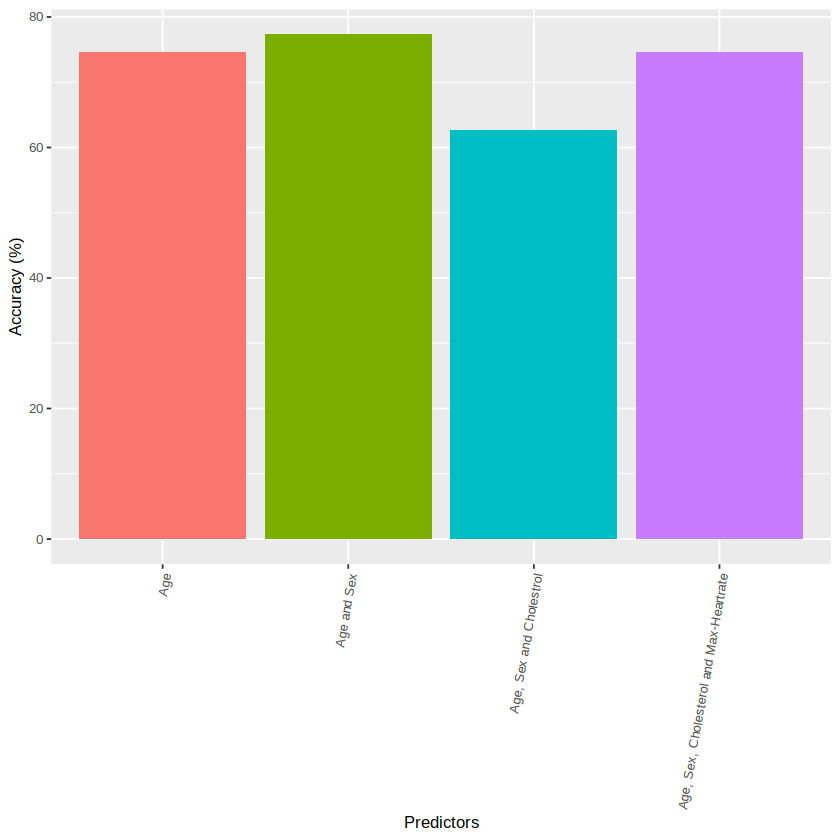

In [19]:
accuracy_plot <- ggplot(accuracy_table, aes(x = predictor, y = accuracy, fill = predictor)) +
                    geom_bar(stat = "identity") +
                    labs(x = "Predictors", y = "Accuracy (%)") +
                    theme(text=element_text(size = 10), axis.text.x = element_text(angle = 80, hjust = 1)) + 
                    guides(fill = "none")
accuracy_plot

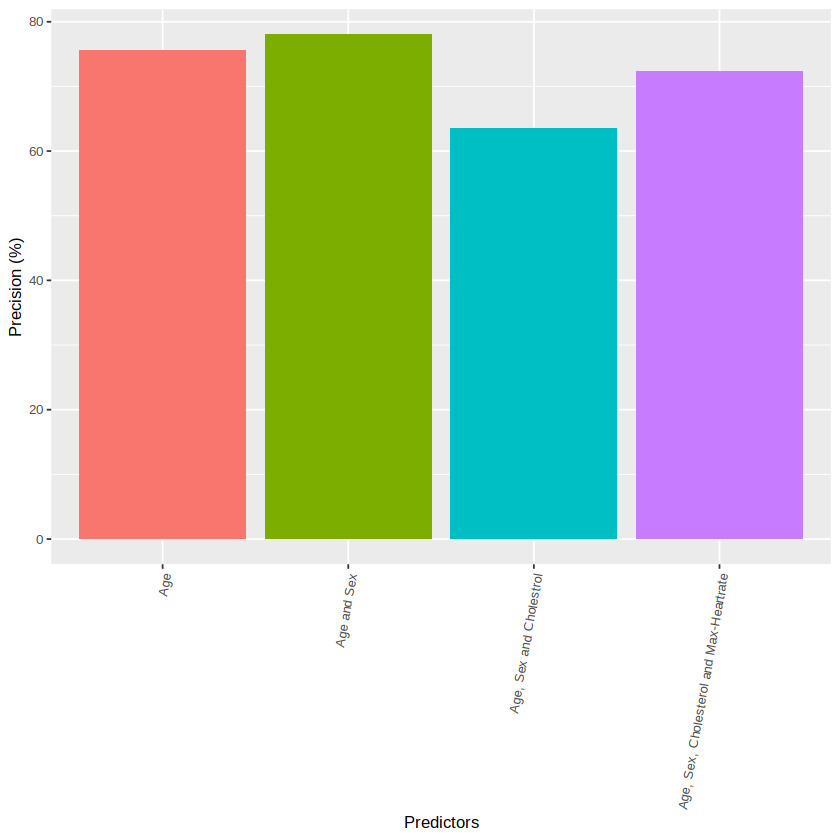

In [18]:
precision_plot <- ggplot(precision_table, aes(x = predictor, y = precision, fill = predictor)) +
                    geom_bar(stat = "identity") +
                    labs(x = "Predictors", y = "Precision (%)") +
                    theme(text=element_text(size = 10), axis.text.x = element_text(angle = 80, hjust = 1)) + 
                    guides(fill = "none")
precision_plot

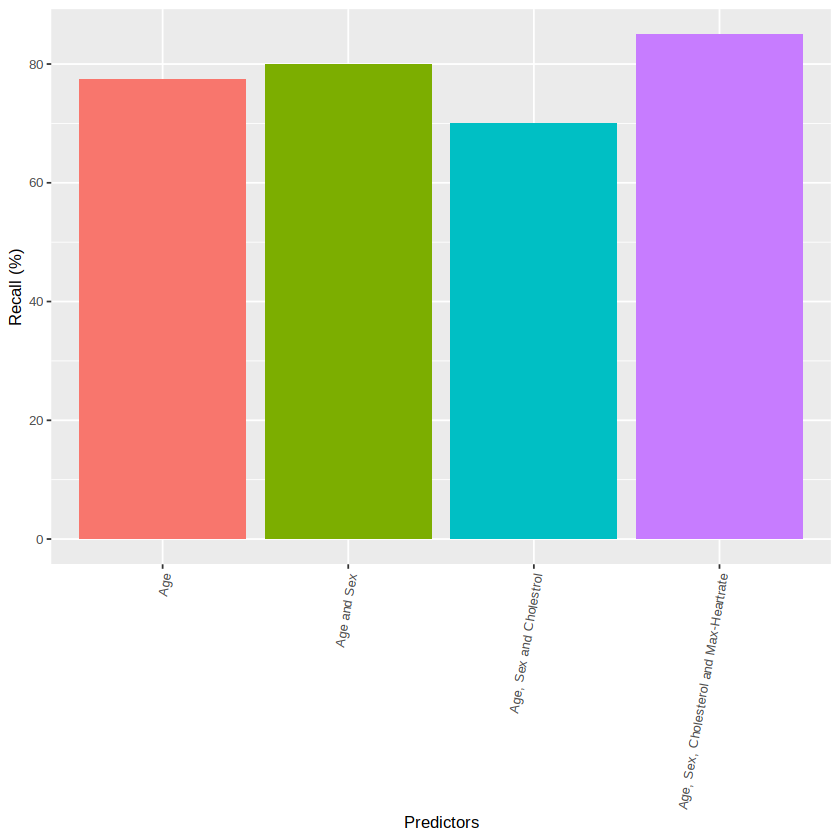

In [17]:
recall_plot <- ggplot(recall_table, aes(x = predictor, y = recall, fill = predictor)) +
                    geom_bar(stat = "identity") +
                    labs(x = "Predictors", y = "Recall (%)") +
                    theme(text=element_text(size = 10), axis.text.x = element_text(angle = 80, hjust = 1)) + 
                    guides(fill = "none")
recall_plot